## U-Net: Convolutional Networks for Biomedical Image Segmentation
https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/ 

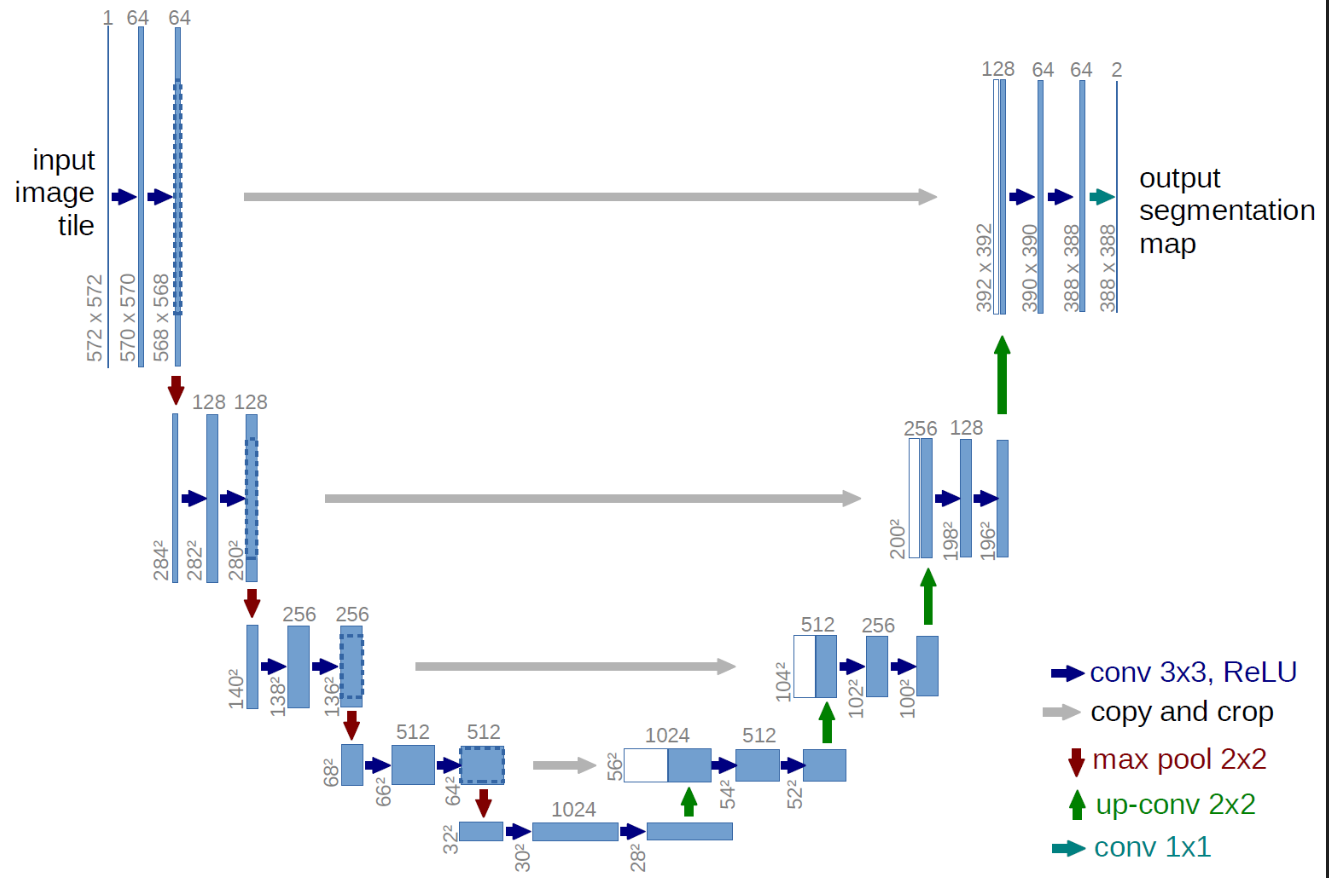

# UNet Pytorch

In [6]:
#import library
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image


# Create Architecture UNet

In [ ]:
def double_conv_layer(input_dim,output_dim):
    con=nn.Sequential(
        nn.Conv2d(input_dim,output_dim,kernel_size=3),
        nn.ReLU(inplace=True), #inplace=True for ReLU operations modifies the input tensor directly, which can lead to reduced memory usage during both training and testing
        nn.Conv2d(output_dim,output_dim,kernel_size=3),
        nn.ReLU(inplace=True)
    )
    return con

def cropped_img(original_tensor,target_tensor):
    target_size=target_tensor.size()[2] # [1,512,56,56] we are getting image value 56
    tensor_size=original_tensor.size()[2] # [1,512,64,64]
    delta_tensor=tensor_size-target_size #64-56=8
    print(target_size,tensor_size,delta_tensor)
    delta_tensor=delta_tensor//2 #8/2=4
    print(delta_tensor)
    #1,512,4:60,4:60 # this this ignore first four , last four pixel of left to right width and top to button for height 
    return original_tensor[:,:,delta_tensor:tensor_size-delta_tensor,delta_tensor:tensor_size-delta_tensor]



In [91]:

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 5 encoder down convolutional layers 
        #Left Side 
        self.en_conv_layer1=double_conv_layer(1,64)
        self.en_conv_layer2=double_conv_layer(64,128)
        self.en_conv_layer3=double_conv_layer(128,256)
        self.en_conv_layer4=double_conv_layer(256,512)
        self.en_conv_layer5=double_conv_layer(512,1024)

        # Decoder/Right Side
        self.de_trans_4=nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=2,stride=2)
        self.de_conv_layer4=double_conv_layer(1024,512)

        self.de_trans_3=nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=2,stride=2)
        self.de_conv_layer3=double_conv_layer(512,256)

        self.de_trans_2=nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2)
        self.de_conv_layer2=double_conv_layer(256,128)

        self.de_trans_1=nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)
        self.de_conv_layer1=double_conv_layer(128,64)

        #output 
        self.out=nn.Conv2d(in_channels=64,out_channels=2,kernel_size=1)




        #this max poolinf will use both in encoder and in decoder part 
        self.en_max_pool1=nn.MaxPool2d(kernel_size=2,stride=2)

    def forward(self,image):
        #encoder part
        #Layer 1
        e1=self.en_conv_layer1(image) #(1,1,572,572) -> (1,64,568,568) apply filter 3*3 two times 
        m1=self.en_max_pool1(e1) #(1,64,568,568) -> (1,64,568/2,568/2)=([1, 64, 284, 284]) apply  max pooling   kernel =3*3 , stride =2 
        #Layer 2
        e2=self.en_conv_layer2(m1)
        m2=self.en_max_pool1(e2)
        #Layer 3
        e3=self.en_conv_layer3(m2)
        m3=self.en_max_pool1(e3)
        #Layer 4
        e4=self.en_conv_layer4(m3)
        m4=self.en_max_pool1(e4)

        #Layer 5
        e5=self.en_conv_layer5(m4)


        #decoder part
        #Layer 4
        t4=self.de_trans_4(e5) # It is a opposite of max pooling
        c4=cropped_img(e4,t4) #original, target 
        d4=self.de_conv_layer4(torch.cat([t4,c4],dim=1)) # dim=1 , concatenates along the channel dimension 512+512=1024 input for de_conv_layer5=double_conv_layer(1024,512)

        #Layer 3
        t3=self.de_trans_3(d4) 
        c3=cropped_img(e3,t3)
        d3=self.de_conv_layer3(torch.cat([t3,c3],dim=1))

        #Layer 2
        t2=self.de_trans_2(d3) 
        c2=cropped_img(e2,t2)
        d2=self.de_conv_layer2(torch.cat([t2,c2],dim=1))

        #Layer 1
        t1=self.de_trans_1(d2) 
        c1=cropped_img(e1,t1)
        d1=self.de_conv_layer1(torch.cat([t1,c1],dim=1))


        
        #output
        output=self.out(d1)
        print(d1.size(),output.size())

        return output




        

        





In [85]:
image_path="tumour.jpg"
img=Image.open(image_path).convert('L')
transform=transforms.Compose([
    transforms.Resize((572,572)),
    transforms.ToTensor()
])

image_tensor=transform(img)
print(image_tensor.shape)
image_tensor=image_tensor.unsqueeze(0)
image_tensor.shape #because model only accept (batch,channel,height, width)
batch_size=1
image_tensor=image_tensor.repeat(batch_size,1,1,1)
image_tensor.shape

torch.Size([1, 572, 572])


torch.Size([1, 1, 572, 572])

In [92]:
model=UNet()
model(image_tensor)


56 64 8
4
104 136 32
16
200 280 80
40
392 568 176
88
torch.Size([1, 64, 388, 388]) torch.Size([1, 2, 388, 388])


tensor([[[[0.0948, 0.0957, 0.0949,  ..., 0.0958, 0.0950, 0.0958],
          [0.0955, 0.0956, 0.0956,  ..., 0.0958, 0.0957, 0.0957],
          [0.0949, 0.0957, 0.0949,  ..., 0.0957, 0.0950, 0.0958],
          ...,
          [0.0956, 0.0956, 0.0956,  ..., 0.0956, 0.0956, 0.0956],
          [0.0949, 0.0957, 0.0949,  ..., 0.0957, 0.0949, 0.0957],
          [0.0956, 0.0956, 0.0955,  ..., 0.0956, 0.0955, 0.0956]],

         [[0.0731, 0.0721, 0.0731,  ..., 0.0722, 0.0731, 0.0722],
          [0.0725, 0.0726, 0.0725,  ..., 0.0726, 0.0724, 0.0726],
          [0.0731, 0.0722, 0.0731,  ..., 0.0722, 0.0731, 0.0722],
          ...,
          [0.0724, 0.0726, 0.0724,  ..., 0.0726, 0.0724, 0.0726],
          [0.0731, 0.0722, 0.0731,  ..., 0.0722, 0.0731, 0.0722],
          [0.0724, 0.0726, 0.0724,  ..., 0.0726, 0.0724, 0.0726]]]],
       grad_fn=<ConvolutionBackward0>)